<font size="+3">Time-series Generative Adversarial Network (TimeGAN): Experiment 9</font>  
from "Machine Learning for Algorithmic Trading" 2nd Ed. by Stefan Jansen

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [2]:
%cd g:\My Drive\Repositoritories\TCN_TimeGAN_Repo\experiment_09

g:\My Drive\Repositoritories\TCN_TimeGAN_Repo\experiment_09


# Imports & Settings

## Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import time
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GRU, Dense, 
                                     RNN, GRUCell, Input, 
                                     Permute, Lambda)
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')

In [4]:
!pip3 install --upgrade tables
!pip3 install keras-tcn --no-dependencies

In [5]:
from tcn_timegan.src.tcn_ae import TCN_AE

## GPU

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


## Parameters

In [7]:
from tcn_timegan.src.params_09 import ( experiment, 
                                        ## Data Parameters
                                        data_file,
                                        ts_names,
                                        start_date,
                                        end_date,

                                        ## Parameters
                                        n_seq, 
                                        seq_len,
                                        batch_size,
                                        train_steps,
                                        gamma,

                                        ##  Network Parameters
                                        hidden_dim,
                                        latent_dim,
                                        n_layers_disc,
                                        n_layers_supv,

                                        ## Generic Loss Functions
                                        mse,
                                        bce,

                                        ## Optimizers
                                        autoencoder_optimizer,
                                        embedding_optimizer,
                                        discriminator_optimizer,
                                        generator_optimizer,
                                        supervisor_optimizer,

                                        ## Pooling Parameters
                                        pooler,
                                        latent_sample_rate )

# Experiment Path

In [8]:
results_path = Path('./tcn_timegan')
if not results_path.exists():
    results_path.mkdir()

In [9]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [10]:
sample_dir = log_dir / 'samples'
if not sample_dir.exists():
    sample_dir.mkdir(parents=True)

In [11]:
evals_dir = log_dir / 'evals'
if not evals_dir.exists():
    evals_dir.mkdir(parents=True)

In [12]:
hdf_store = log_dir / f'TimeSeriesGAN_{experiment:02}.h5'

# Prepare Data

## Get Data

In [ ]:
data = pd.read_csv(log_dir/ 'data' /data_file) 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    512 non-null    object 
 1   PDSI    512 non-null    float64
 2   PHDI    512 non-null    float64
 3   PMDI    512 non-null    float64
 4   PZI     512 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.1+ KB


In [ ]:
data.head()

,date,PDSI,PHDI,PMDI,PZI
0,1895Q1,-0.86,-0.86,-0.86,-2.59
1,1895Q2,-1.27,-1.27,-1.27,-1.88
2,1895Q3,0.42,-0.78,0.42,0.58
3,1895Q4,-0.90,-0.90,-0.90,-2.23
4,1896Q1,-1.34,-1.34,-1.34,-2.02


In [ ]:
data.tail()

,date,PDSI,PHDI,PMDI,PZI
507,2021Q4,5.80,5.83,5.83,-1.88
508,2022Q1,-99.99,4.06,3.94,2.02
509,2022Q2,-99.99,-99.99,-99.99,-99.99
510,2022Q3,-99.99,-99.99,-99.99,-99.99
511,2022Q4,-99.99,-99.99,-99.99,-99.99


In [ ]:
data.to_hdf(hdf_store, 'data/real')

## Plot Series

In [13]:
tickers = ts_names

In [14]:
df = pd.read_hdf(hdf_store, 'data/real')
df = df.set_index(['date'])     # use DateTime index

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512 entries, 1895Q1 to 2022Q4
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PDSI    512 non-null    float64
 1   PHDI    512 non-null    float64
 2   PMDI    512 non-null    float64
 3   PZI     512 non-null    float64
dtypes: float64(4)
memory usage: 20.0+ KB


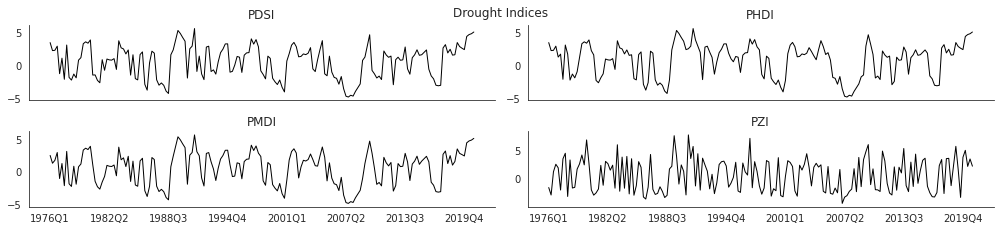

In [16]:
axes = df.loc[start_date:end_date].plot(subplots=True,
                                        figsize=(14, 6),
                                        layout=(n_seq, 2),
                                        title=tickers,
                                        legend=False,
                                        rot=0,
                                        lw=1, 
                                        color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Drought Indices')
plt.gcf().tight_layout()
sns.despine();

## Correlation

In [ ]:
df.corr()

,PDSI,PHDI,PMDI,PZI
PDSI,1.000000,0.856780,0.860684,0.839309
PHDI,0.856780,1.000000,0.996446,0.951904
PMDI,0.860684,0.996446,1.000000,0.959516
PZI,0.839309,0.951904,0.959516,1.000000


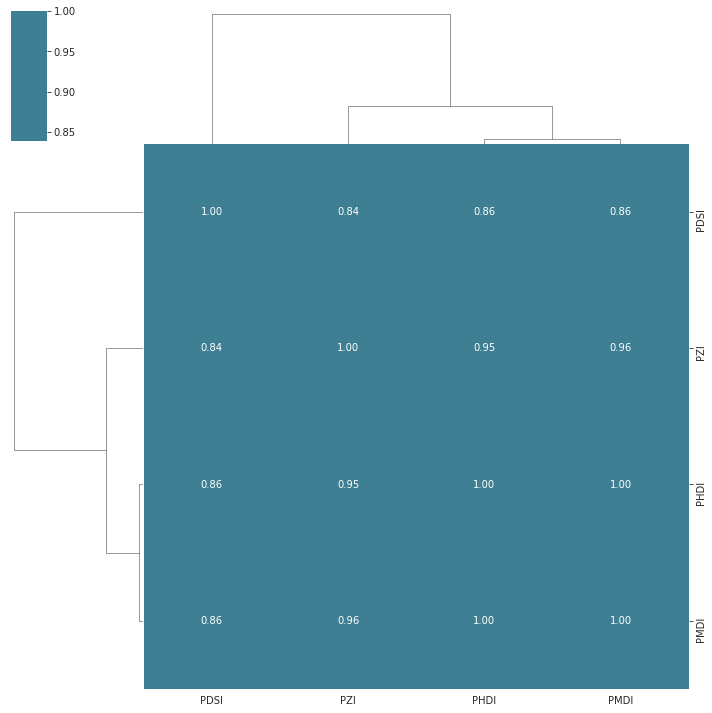

In [ ]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [17]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [18]:
data = []
for i in range(len(df)-seq_len): 
  data.append(scaled_data[i:i + seq_len])
n_windows = len(data)
print(n_windows)

332


In [ ]:
[len(data), data[0].shape]

[332, (180, 4)]

## Create tf.data.Dataset

In [19]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [20]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [21]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the supervisor and discriminator follows the author's sample code. The embedder, recovery and generator are based on the Temporal Convolutional Network (TCN).

## Set up logger

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Block generator (RNN)

In [ ]:
def make_rnn(input_shape, n_layers, hidden_units, output_units, name):
    return Sequential([Input(shape=input_shape)] +      
                      [GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRUvy_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Generator (TCN), Discriminator and Supervisor (RNN) 

In [ ]:
tcn_ae = TCN_AE(ts_len=seq_len, ts_dimension=n_seq, latent_sample_rate=latent_sample_rate, pooler=pooler)
tcn_generator = tcn_ae.build_encoder()

Model: "TCN_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 4)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74068     
                                                                 
 TCN_Decoder (Functional)    (None, 180, 4)            75664     
                                                                 
Total params: 149,732
Trainable params: 149,732
Non-trainable params: 0
_________________________________________________________________
Model: "TCN_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 4)]          0         
                                                                 
 tcn-enc (TCN)          

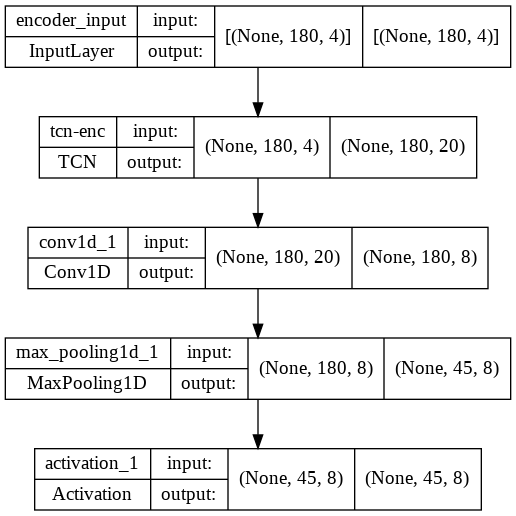

In [ ]:
plot_model(tcn_generator, show_shapes=True)

In [ ]:
supervisor = make_rnn(input_shape=[45, 8], 
                          n_layers=n_layers_supv, 
                          hidden_units=latent_dim, 
                          output_units=latent_dim, 
                          name='Supervisor')

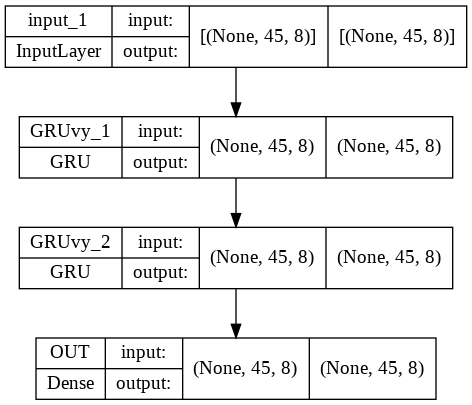

In [ ]:
plot_model(supervisor, show_shapes=True)

In [ ]:
discriminator = make_rnn(input_shape=[45, 8],
                         n_layers=n_layers_disc, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')

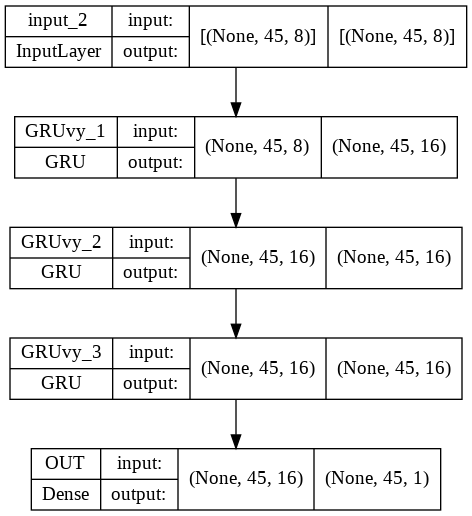

In [ ]:
plot_model(discriminator, show_shapes=True)

## Input place holders

In [ ]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [ ]:
tcn_generator(X).shape

TensorShape([None, 45, 8])

In [ ]:
discriminator(tcn_generator(X)).shape

TensorShape([None, 45, 1])

In [ ]:
supervisor(tcn_generator(X)).shape

TensorShape([None, 45, 8])

# TimeGAN Training

# Phase 1: Autoencoder Training

## Architecture TCN

In [ ]:
embedder = tcn_ae.build_encoder()
recovery = tcn_ae.build_decoder()

Model: "TCN_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 4)]          0         
                                                                 
 tcn-enc (TCN)               (None, 180, 20)           73900     
                                                                 
 conv1d_2 (Conv1D)           (None, 180, 8)            168       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 45, 8)            0         
 1D)                                                             
                                                                 
 activation_2 (Activation)   (None, 45, 8)             0         
                                                                 
Total params: 74,068
Trainable params: 74,068
Non-trainable params: 0
___________________________________________________

In [ ]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')
autoencoder.summary()                   

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 180, 4)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74068     
                                                                 
 TCN_Decoder (Functional)    (None, 180, 4)            75664     
                                                                 
Total params: 149,732
Trainable params: 149,732
Non-trainable params: 0
_________________________________________________________________


## Autoencoder Training Step

In [ ]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)        
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)
        
    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [04:15<00:00, 39.12it/s]


## Persist Autoencoder Model

In [ ]:
autoencoder.save(log_dir / 'autoencoder')

INFO:tensorflow:Assets written to: tcn_timegan/experiment_09/autoencoder/assets


INFO:tensorflow:Assets written to: tcn_timegan/experiment_09/autoencoder/assets


# Phase 2: Supervised training

In [ ]:
autoencoder = tf.keras.models.load_model(log_dir / 'autoencoder')

## Supervisor Train Step

In [ ]:
@tf.function
def train_supervisor(x):    
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])
    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Supervisor Training Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [01:22<00:00, 121.14it/s]


## Persist Supervisor Model

In [ ]:
supervisor.save(log_dir / 'supervisor')

INFO:tensorflow:Assets written to: tcn_timegan/experiment_09/supervisor/assets


INFO:tensorflow:Assets written to: tcn_timegan/experiment_09/supervisor/assets


In [ ]:
supervisor = tf.keras.models.load_model(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [ ]:
E_hat = tcn_generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
E_hat.shape

TensorShape([None, 45, 8])

In [ ]:
H_hat.shape

TensorShape([None, 45, 8])

In [ ]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 180, 4)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74068     
                                                                 
 Supervisor (Sequential)     (None, 45, 8)             936       
                                                                 
 Discriminator (Sequential)  (None, 45, 1)             4529      
                                                                 
Total params: 79,533
Trainable params: 79,533
Non-trainable params: 0
_________________________________________________________________


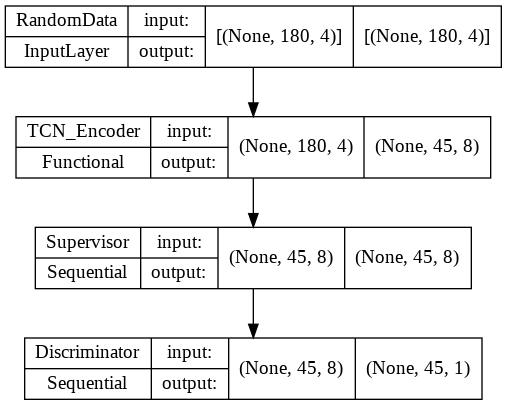

In [ ]:
plot_model(adversarial_supervised, show_shapes=True)

### Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 180, 4)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74068     
                                                                 
 Discriminator (Sequential)  (None, 45, 1)             4529      
                                                                 
Total params: 78,597
Trainable params: 78,597
Non-trainable params: 0
_________________________________________________________________


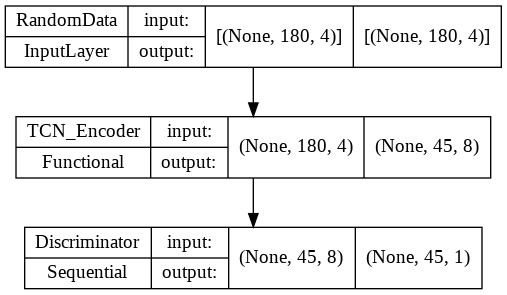

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

## Synthesizer

In [ ]:
X_hat = recovery(H_hat)
synthesizer = Model(inputs=Z,
                       outputs=X_hat,
                       name='Synthesizer')

In [ ]:
synthesizer.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 180, 4)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74068     
                                                                 
 Supervisor (Sequential)     (None, 45, 8)             936       
                                                                 
 TCN_Decoder (Functional)    (None, 180, 4)            75664     
                                                                 
Total params: 150,668
Trainable params: 150,668
Non-trainable params: 0
_________________________________________________________________


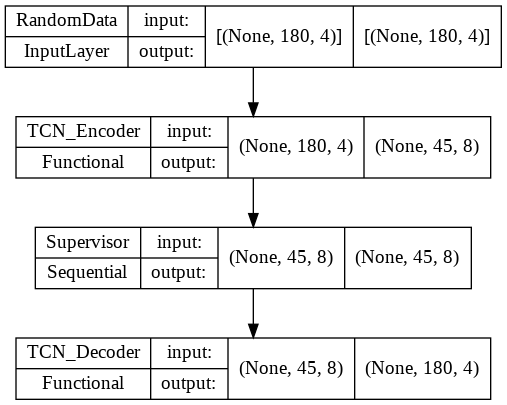

In [ ]:
plot_model(synthesizer, show_shapes=True)

### Moment Loss and Roughness Loss

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [ ]:
def get_roughness_loss(x,y):
  #
  t = (x - y).numpy()
  ts_loss = np.sum(np.sum(np.diff(t, n=2, axis=0)**2, axis=0)/len(x), axis=0)
  return sum(ts_loss)

## Discriminator

### Architecture: Real Data

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 180, 4)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 45, 8)             74068     
                                                                 
 Discriminator (Sequential)  (None, 45, 1)             4529      
                                                                 
Total params: 78,597
Trainable params: 78,597
Non-trainable params: 0
_________________________________________________________________


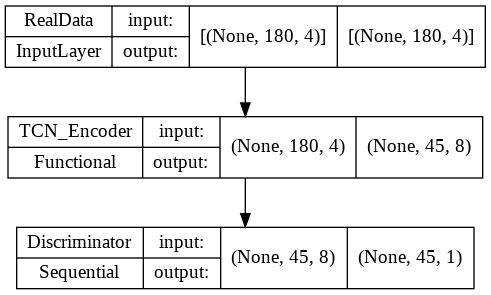

In [ ]:
plot_model(discriminator_model, show_shapes=True)

## Generator Train Step

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthesizer(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)
        generator_roughness_loss = get_roughness_loss(x, x_hat)
        
        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss +
                          generator_roughness_loss)
    
    var_list = tcn_generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss, generator_roughness_loss

## Embedding Train Step

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [ ]:
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Joint Training Loop

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
min_loss = np.inf
patience = 4
brk_crit = 1e-4
wait = 0

In [ ]:
tf.config.run_functions_eagerly(True)

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_g_loss_r = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v, step_g_loss_r = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)
        
    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 100 == 0: 
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.6f} | g_loss_v: {step_g_loss_v:6.4f} | g_loss_r: {step_g_loss_r:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')
        
        wait += 1
        if min_loss - step_g_loss_s >= brk_crit:
          min_loss =  step_g_loss_s
          wait = 0
        if wait >= patience:
          break
        
    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('G Loss R', step_g_loss_r, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)
import pdb;pdb.set_trace()                          
synthesizer.save(log_dir / 'synthesizer')        

     0 | d_loss: 2.0433 | g_loss_u: 0.6750 | g_loss_s: 0.0009 | g_loss_v: 0.1770 | g_loss_r: 2.0007 | e_loss_t0: 0.0128
   100 | d_loss: 0.1823 | g_loss_u: 3.8808 | g_loss_s: 0.0000 | g_loss_v: 0.0684 | g_loss_r: 1.8537 | e_loss_t0: 0.0127
   200 | d_loss: 0.5366 | g_loss_u: 3.7286 | g_loss_s: 0.0000 | g_loss_v: 0.0527 | g_loss_r: 1.4499 | e_loss_t0: 0.0127
   300 | d_loss: 0.1490 | g_loss_u: 4.8966 | g_loss_s: 0.0000 | g_loss_v: 0.0495 | g_loss_r: 1.3298 | e_loss_t0: 0.0126
   400 | d_loss: 0.1475 | g_loss_u: 5.1951 | g_loss_s: 0.0000 | g_loss_v: 0.0475 | g_loss_r: 1.1956 | e_loss_t0: 0.0127


KeyboardInterrupt: ignored

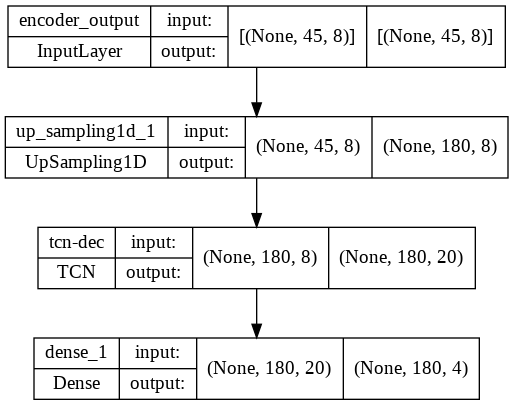

In [ ]:
plot_model(recovery, show_shapes=True)

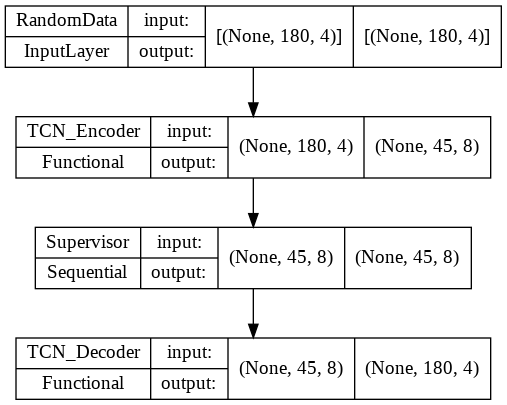

In [ ]:
plot_model(synthesizer, show_shapes=True)

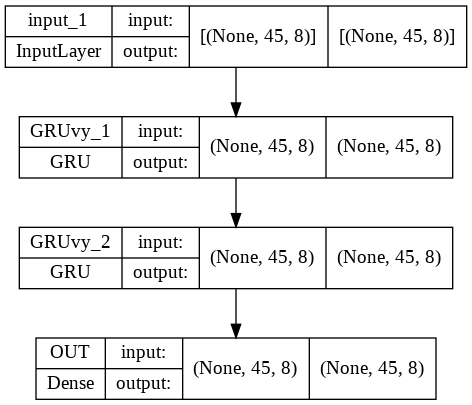

In [ ]:
plot_model(supervisor, show_shapes=True)

In [22]:
synthesizer = tf.keras.models.load_model(log_dir / 'synthesizer')

In [23]:
real_data = np.stack(data)
real_data.shape

(332, 180, 4)

# Generate Synthetic Data

In [24]:
generated_data = []
for i in range(int(512/128)):
    Z_ = next(random_series)
    d = synthesizer(Z_)
    generated_data.append(d)

In [25]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(512, 180, 4)

In [ ]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [26]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(512, 180, 4)

In [27]:
real_data = (scaler.inverse_transform(np.stack(data)
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
real_data.shape

(332, 180, 4)

## Persist Data

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

In [ ]:
import os

In [28]:
generated_data.shape

(512, 180, 4)

In [29]:
real_data.shape

(332, 180, 4)


Sample Plot: 6


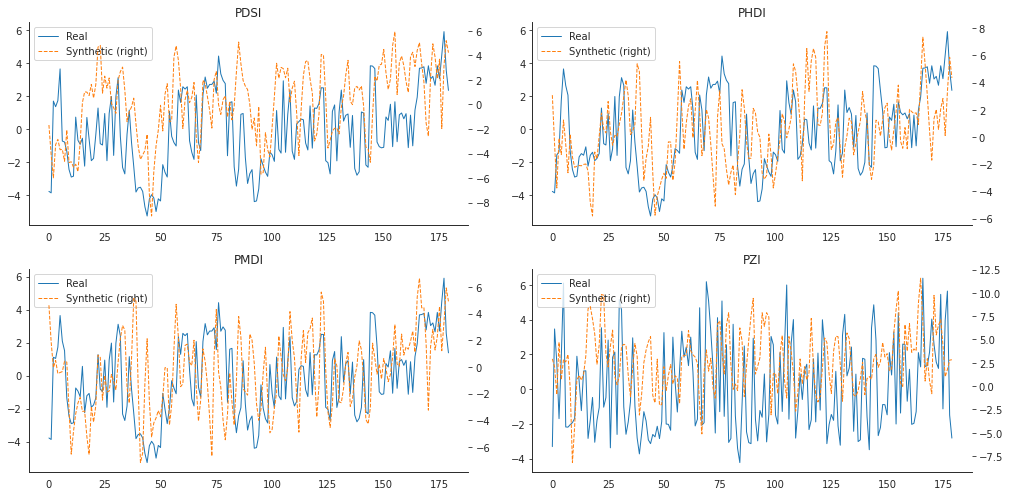


Sample Plot: 7


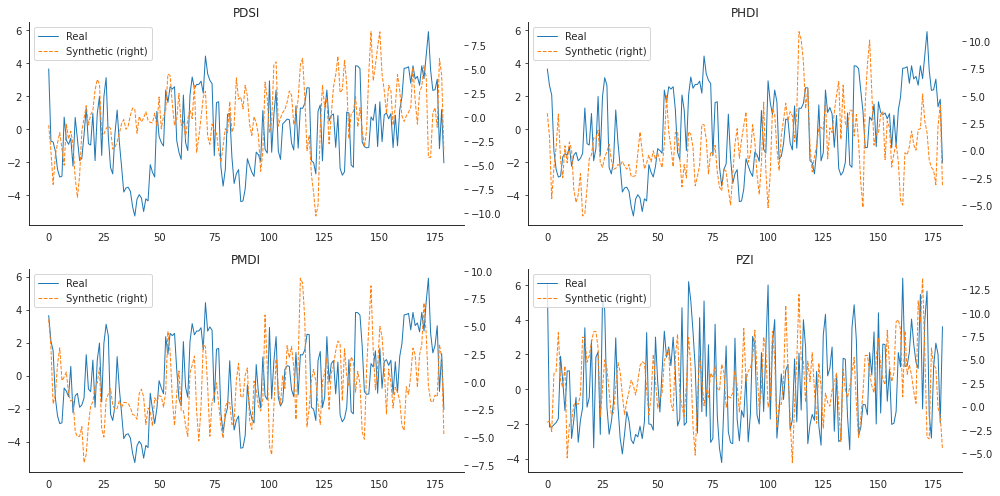


Sample Plot: 8


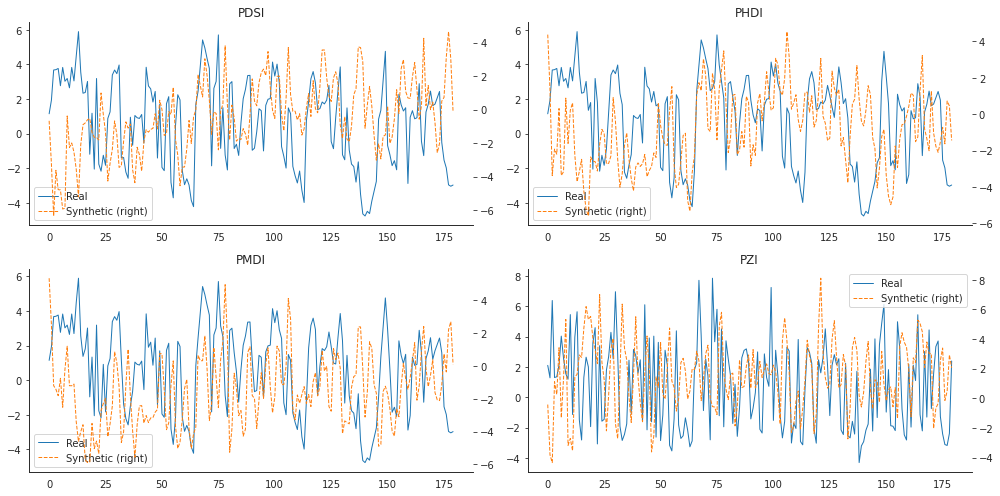


Sample Plot: 9


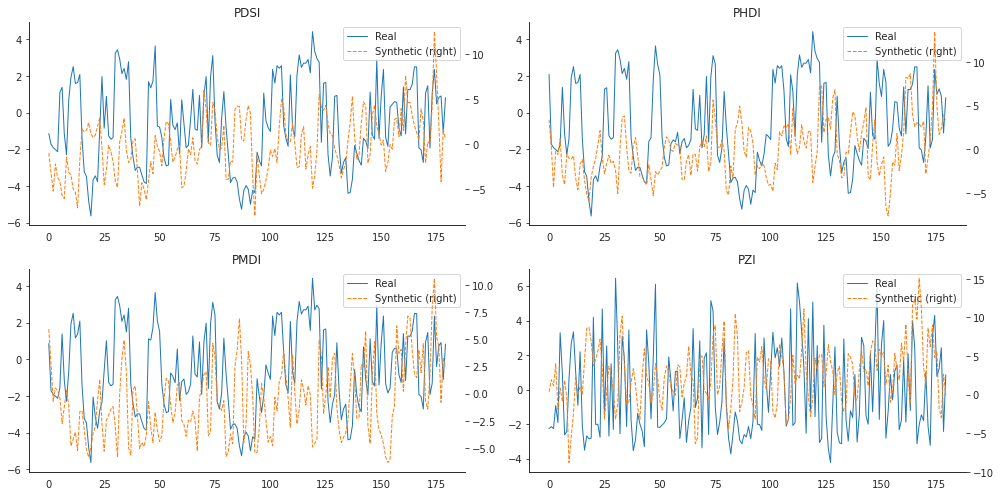


Sample Plot: 10


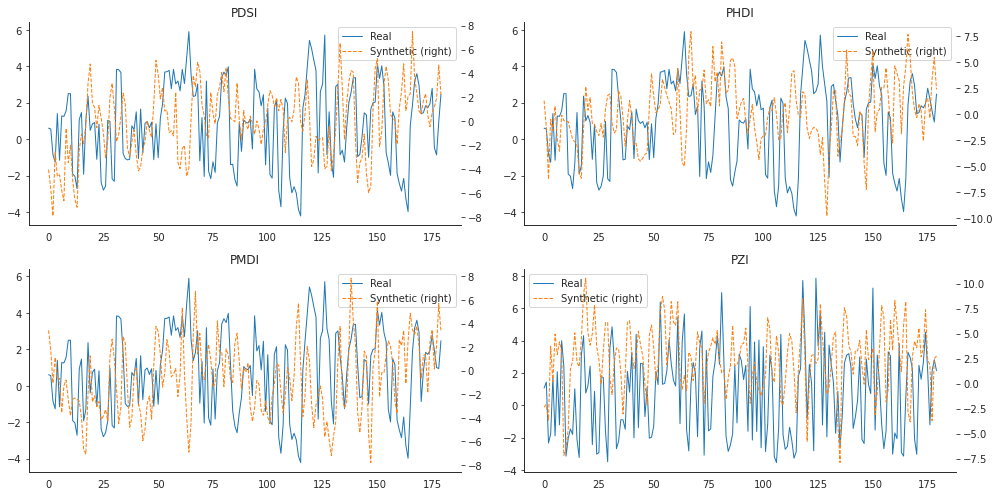

In [30]:
n_init = 5
n_plots = 5

for n in range(n_init, n_init + n_plots):
  print("\nSample Plot: %d" % (n + 1))
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
  axes = axes.flatten()
  
  idx = np.random.randint(len(real_data))
  synthetic = generated_data[idx]
  real = real_data[idx]

  for j, ticker in enumerate(tickers):
      (pd.DataFrame({'Real': real[:, j],
                    'Synthetic': synthetic[:,j]})
      .plot(ax=axes[j],
            title=ticker,
            secondary_y='Synthetic', style=['-', '--'],
            lw=1))
  sns.despine()

  fig.tight_layout()
  plt.show()
  f_name = os.path.join(log_dir, "samples", "sample_" + str(n + 1 ) + ".png")
  fig.savefig(f_name)

In [ ]:
np.sum(np.diff(real - synthetic, n=2, axis=0)**2, axis=0)/180

array([24.723362, 16.187386, 18.225237, 69.575676], dtype=float32)

In [ ]:
np.sum(np.diff(real, n=2, axis=0)**2, axis=0)/180

array([12.735094,  8.254612, 11.945471, 42.374413], dtype=float32)

In [ ]:
np.sum(np.diff(synthetic, n=2, axis=0)**2, axis=0)/180

array([13.239264,  8.596266,  6.356606, 26.874086], dtype=float32)

In [ ]:
def get_rough_loss(x,y):
  ts_loss = np.sum(np.diff(x - y, n=2, axis=0)**2, axis=0)/len(x)
  return sum(ts_loss)

In [ ]:
get_rough_loss(real, synthetic)

128.71166038513184